# Exploration Notebook (UCI-ID 50, Image Segmentation)

## Imports

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:

import networkx as nx
import pandas as pd
import seaborn as sb
import umap.plot
from ucimlrepo import fetch_ucirepo

D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, erro

In [5]:
import sys

sys.path.append("../")
import evaluation
import visualization
import processing
from embedding_obj import EmbeddingObj
from dash_overlay import DashOverlay


## Workflow Example

In [6]:
# fetch dataset (available at https://archive.ics.uci.edu/dataset/50/image+segmentation)
image_segmentation = fetch_ucirepo(id=50)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets)

target_feature = "saturation-mean"
labels = pd.Categorical(y["class"]).codes

X.head()

,region-centroid-col,region-centroid-row,region-pixel-count,short-line-density-5,short-line-density-2,vedge-mean,vedge-sd,hedge-mean,hedge-sd,intensity-mean,rawred-mean,rawblue-mean,rawgreen-mean,exred-mean,exblue-mean,exgreen-mean,value-mean,saturation-mean,hue-mean
0,140.0,125.0,9.0,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333333,7.666667,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,188.0,133.0,9.0,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666667,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,105.0,139.0,9.0,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333333,3.333333,-7.666667,7.555555,0.532628,-0.965946
3,34.0,137.0,9.0,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,39.0,111.0,9.0,0.0,0.0,0.722222,0.374074,0.888889,0.429630,6.037037,7.000000,7.666667,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


<Axes: ylabel='Count'>

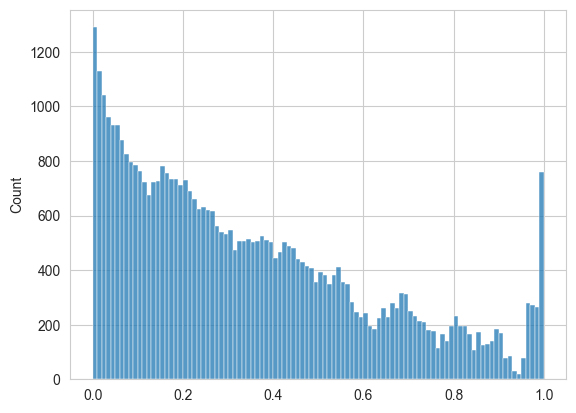

In [7]:
connectivity_pairwise = processing.compute_pairwise_dist(X, [target_feature])
sb.histplot(connectivity_pairwise.flatten(), bins=100)

### 0. Compute initial UMAP-Embedding

In [8]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]

graph_knn_feat, edge_weights_knn_feat = processing.compute_graph_weights(X, [
    target_feature],
                                                                         n_neighbors=5)

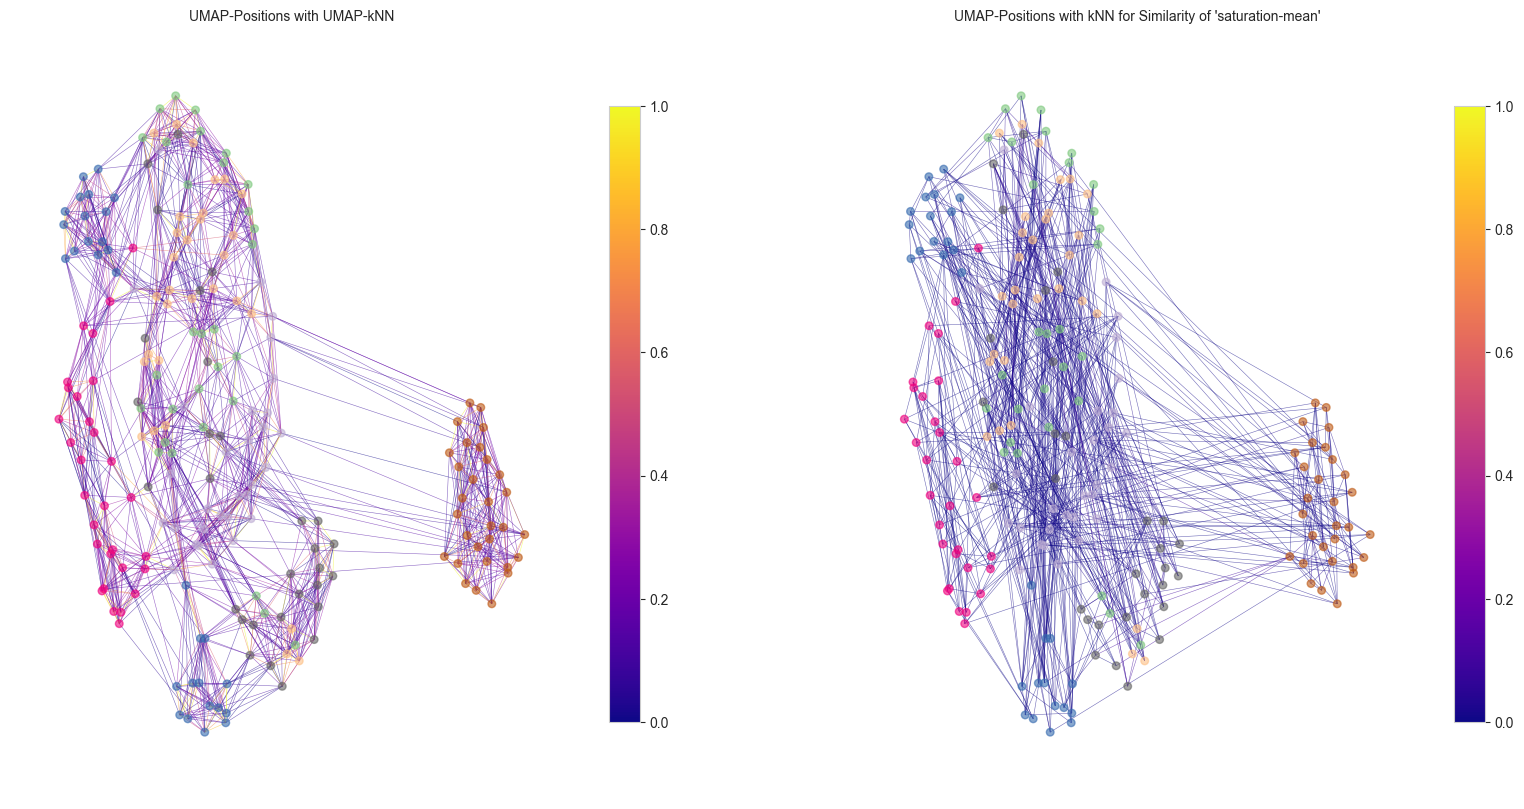

In [11]:
knn_list = [EmbeddingObj(graph=graph_umap_knn, embedding=umap_embedding,
                         edge_weights=edge_weights_umap_knn,
                         title="UMAP-Positions with UMAP-kNN",
                         labels={i: labels[i] for i in range(len(labels))}),
            EmbeddingObj(graph=graph_knn_feat, embedding=umap_embedding,
                         edge_weights=edge_weights_knn_feat,
                         title=f"UMAP-Positions with kNN for Similarity of '{target_feature}'",
                         labels={i: labels[i] for i in range(len(labels))})
            ]

visualization.display_graphs(knn_list,
                             figsize_columns=2,
                             figsize=(20, 10))

### 1. Compute modified Embeddings

In [12]:
embeddings = processing.fit(X, umap_embedding, [target_feature],
                            iterations=[1, 3, 5, 10])

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  3
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  5
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  10
Computation finished
------------------------------------------------------------


### 2. Add Metrics to modified Embeddings

In [13]:
embeddings = evaluation.compute_pairwise_metrics(X, embeddings)
embeddings = evaluation.compute_global_metrics(X, embeddings, [target_feature])
embeddings[0].metrics_info()

------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  1
Computation time:  0.013001680374145508
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  3
Computation time:  0.007995128631591797
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  5
Computation time:  0.008001565933227539
------------------------------------------------------------
------------------------------------------------------------
Computing pairwise metrics for embedding with marker:  10
Computation time:  0.00700068473815918
------------------------------------------------------------
------------------------------------------------------------
Computing global metrics for embedding with marker:  1
Computat

### 3. Visualize Results

### 3.1 Static Graphs

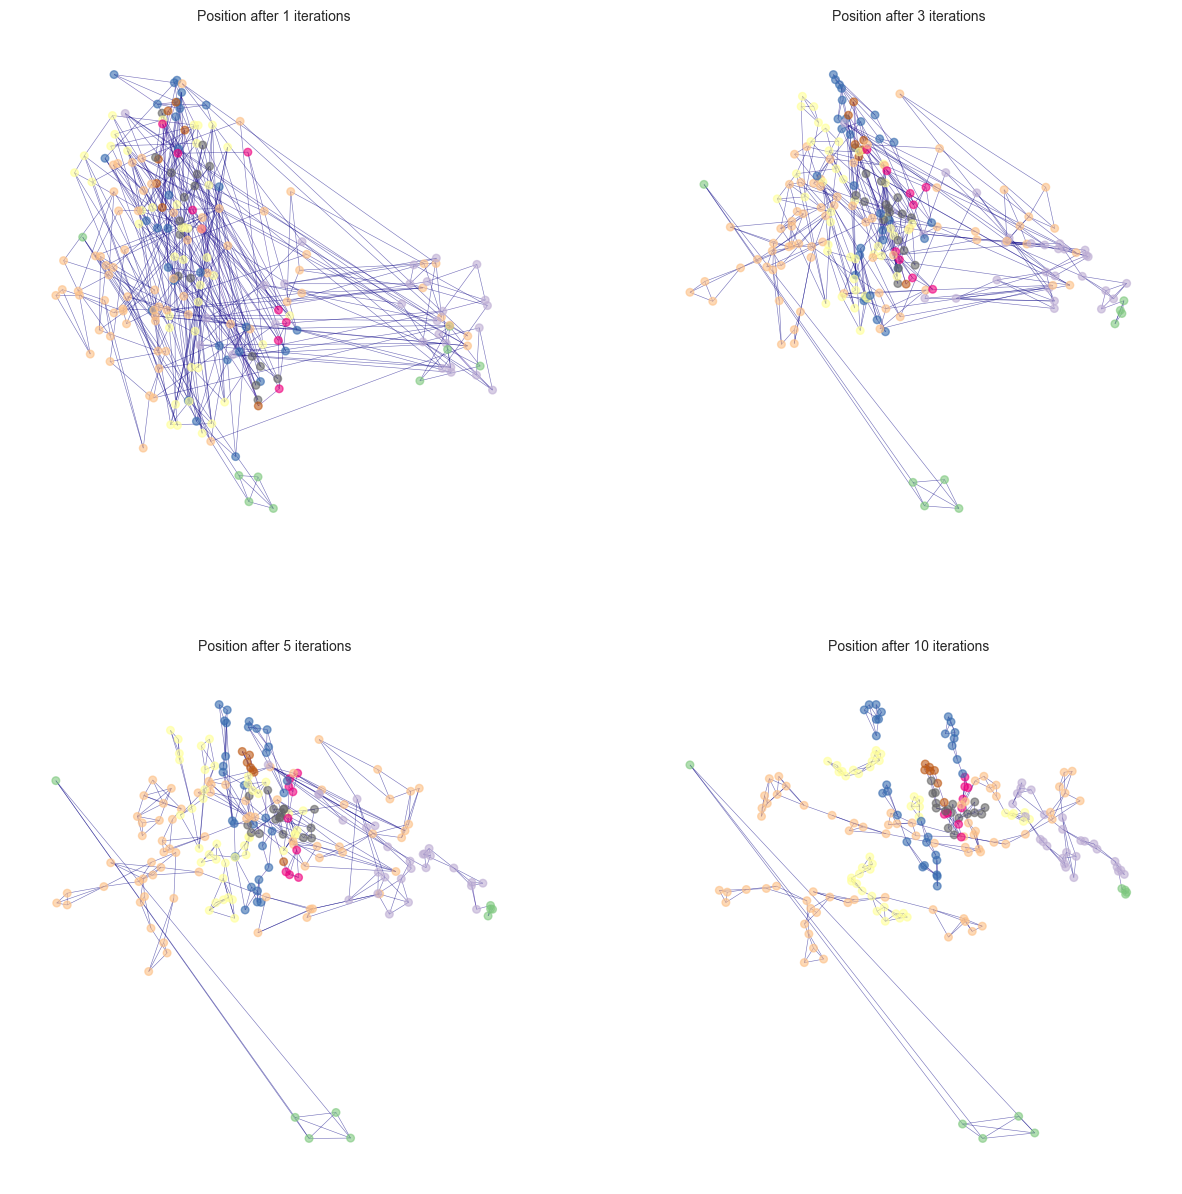

In [14]:
for emb in embeddings:
    emb.labels = {i: X.at[i, target_feature] for i in range(len(labels))}

visualization.display_graphs(embeddings, show_cbar=False)

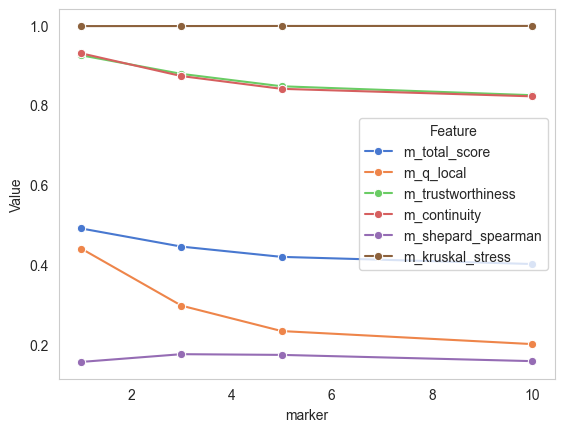

In [15]:
metrics_df = evaluation.metrics_report(embeddings)
visualization.plot_metrics_report(metrics_df)

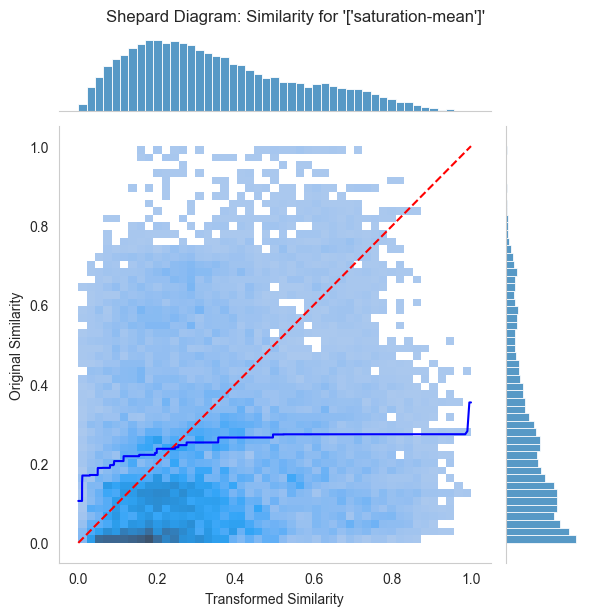

In [16]:
visualization.plot_shepard_diagram(X, embeddings[0], [target_feature])

### 3.2 Interactive Dash-App

In [17]:
# utils.save_pickle(embeddings)

In [18]:
# embeddings = utils.load_pickle(filename="results_20250408-155308")

In [19]:
dash_app = DashOverlay(embeddings)

In [20]:
dash_app.run()

OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.